# Importing dependencies

In [1]:
# Import necessary libraries
import os
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.transforms import RandomAffine, ToPILImage, ToTensor
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn.functional as F
from sklearn.base import BaseEstimator
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, auc
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import FunctionTransformer
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image
from joblib import Parallel, delayed
import multiprocessing

# Importing dataset

In [2]:
resize_transform = transforms.Resize((224, 224))
validation_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Define the dataset path (the directory containing "benign" and "malignant" subfolders)
dataset_path = 'C:/Users/User/Desktop/NUS/IT1244/images'

# Load the dataset using ImageFolder
standard_dataset = ImageFolder(root=dataset_path, transform=resize_transform)

## Verifying dataset and visualising images

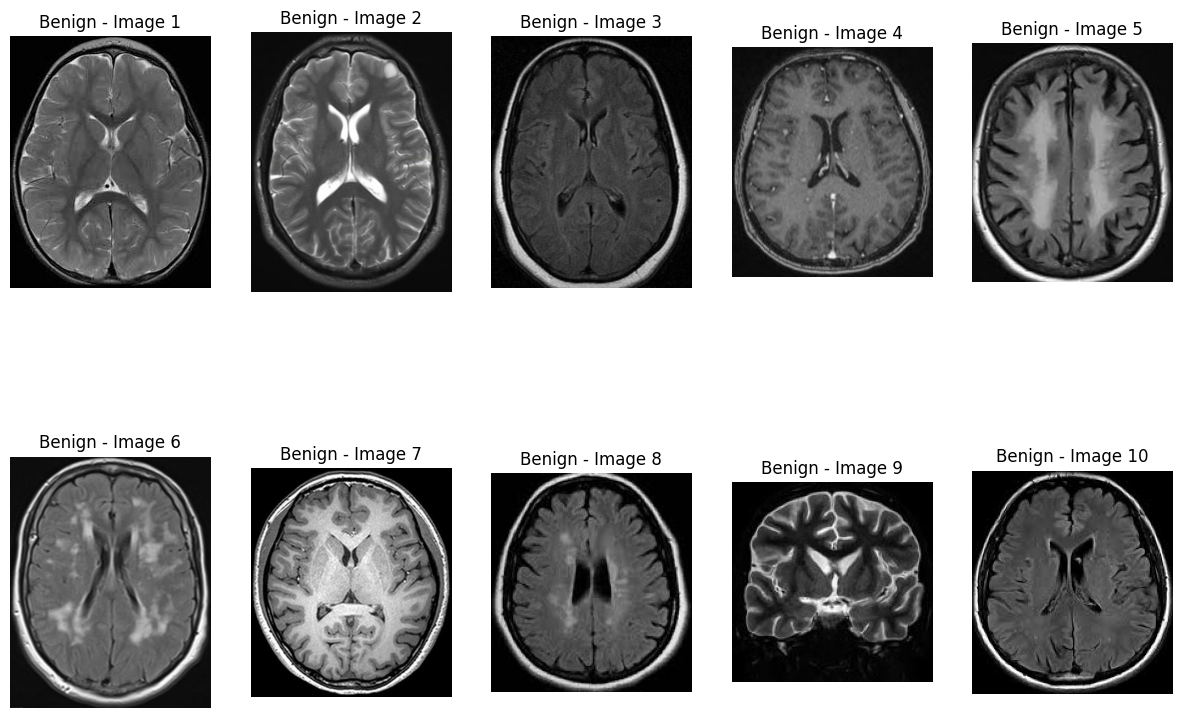

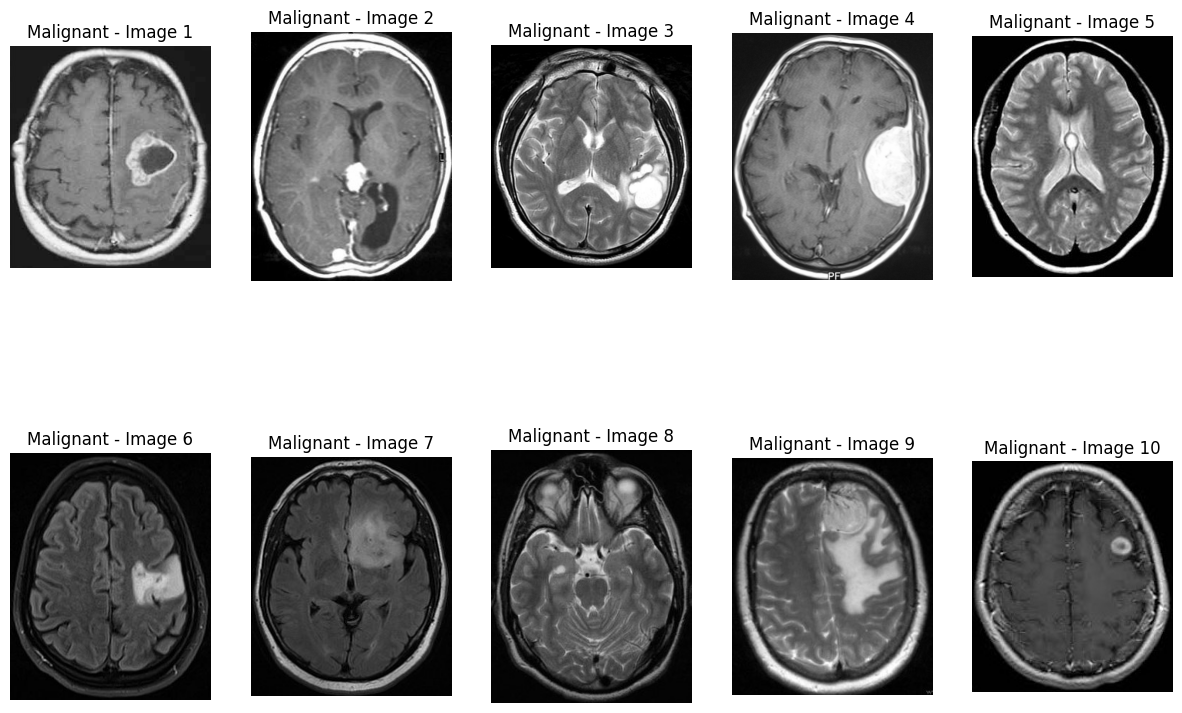

In [8]:
# Create a mapping from class index to class name
class_names = standard_dataset.classes

# Separate images into benign and malignant categories
benign_images = [item for item in standard_dataset.samples if item[1] == class_names.index('benign')]
malignant_images = [item for item in standard_dataset.samples if item[1] == class_names.index('malignant')]

# Randomly select 10 images from each category
random.shuffle(benign_images)
random.shuffle(malignant_images)
benign_samples = benign_images[:10]
malignant_samples = malignant_images[:10]

# Plot the top 10 benign images
plt.figure(figsize=(15, 10))
for i, (image_path, label) in enumerate(benign_samples):
    img = Image.open(image_path)
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(f'Benign - Image {i + 1}')
    plt.axis('off')

# Plot the top 10 malignant images
plt.figure(figsize=(15, 10))
for i, (image_path, label) in enumerate(malignant_samples):
    img = Image.open(image_path)
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(f'Malignant - Image {i + 1}')
    plt.axis('off')

plt.show()

## Image Augmentation

In [3]:
class Augmentation:
  """
  Custom image augmentation class for applying multiple transformations to input images.

  Parameters:
  - num_augmentations (int): The number of augmentations to apply to each input image.
  - translation (tuple of floats): Maximum absolute fraction for horizontal and vertical translations.
  - shear (tuple of floats): Range of shearing angles (degrees).
  - rotation (tuple of floats): Range of clockwise rotation angles (degrees).

  Methods:
  - __call__(self, img_label): Apply augmentations to an input image-label pair.

  Usage:
  Instantiate the class and call it with an image-label pair to generate augmented images.

  Returns:
  - augmentations (list): A list of augmented image-label pairs. Each pair consists of an augmented image (torch.Tensor) and the original label.

  Example:
  augmentation = Augmentation()
  augmented_images = augmentation((input_image, input_label))
  """
  def __init__(self):
    self.num_augmentations = 10
    self.translation = (15 / 224, 15 / 224)
    self.shear = (-15, 15)
    self.rotation = (-25, 25)
    self.toTensor = transforms.ToTensor()
    self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

  def __call__(self, img_label):
    img, label = img_label
    augmentations = []
    for _ in range(self.num_augmentations):
      aug_transform = RandomAffine(degrees=self.rotation, translate=self.translation, shear=self.shear)
      new_img = aug_transform(img)
      new_img = self.toTensor(new_img)
      new_img = self.normalize(new_img)
      augmentations.append((new_img, label))

    return augmentations

### Image Augmentation Tests

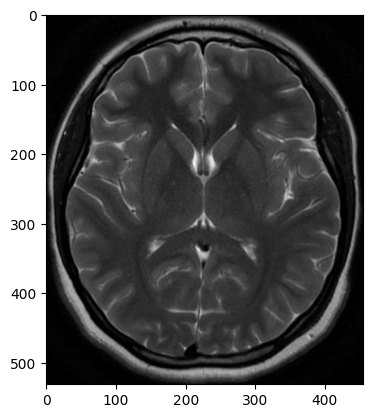

In [4]:
# Load a sample image for visualization
test = standard_dataset.samples[0]
img_test = Image.open(test[0])
plt.imshow(img_test)

### Augmentation Sanity Check on Relevant Data Formats from Stratified K Fold Cross Validation

Training Fold 1/5
Initial: 184, After Augmentation: 1840
Image 1 - Size: torch.Size([3, 224, 224])


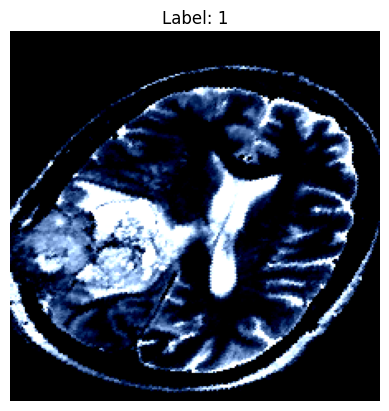

Image 2 - Size: torch.Size([3, 224, 224])


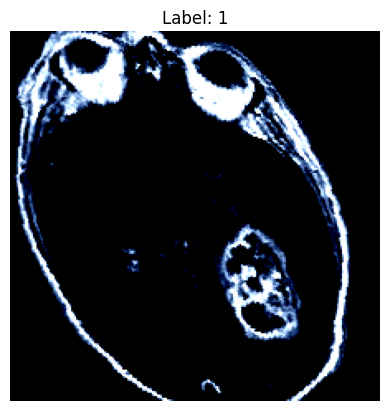

Image 3 - Size: torch.Size([3, 224, 224])


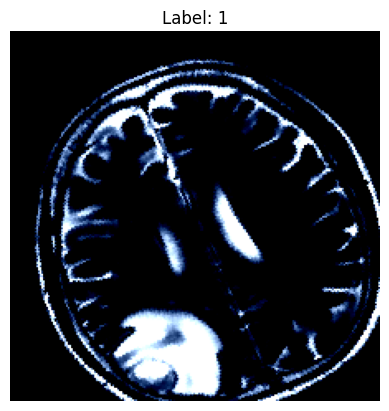

Image 4 - Size: torch.Size([3, 224, 224])


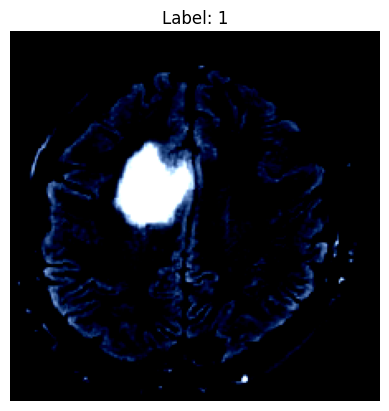

Image 5 - Size: torch.Size([3, 224, 224])


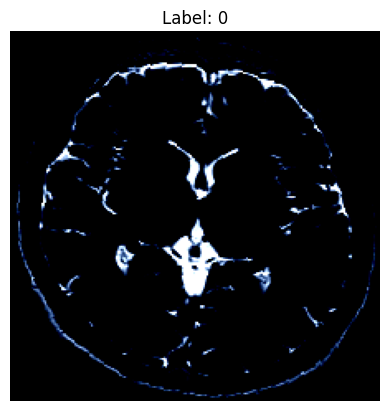

In [7]:
def visualize_augmented_images(dataset, num_folds=5, batch_size=32, max_images_to_display=5):
    """
    Visualize augmented images from a dataset using Stratified K-Fold cross-validation.

    Parameters:
    - dataset (torch.utils.data.Dataset): The dataset to perform cross-validation on.
    - num_folds (int): The number of cross-validation folds.
    - batch_size (int): Batch size for loading augmented images.
    - max_images_to_display (int): Maximum number of images to display per batch.

    Returns:
    None
    """

    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
    augmentation = Augmentation()

    for fold, (train_index, val_index) in enumerate(skf.split(dataset.imgs, [y for x, y in dataset.samples])):
        print(f"Training Fold {fold + 1}/{num_folds}")

        train_dataset = torch.utils.data.Subset(dataset, train_index)

        augmented_images = []
        for img_label in train_dataset:
            augmented_images.extend(augmentation(img_label))
        dataloader = DataLoader(augmented_images, batch_size=batch_size, shuffle=True)
        print(f"Initial: {len(train_dataset)}, After Augmentation: {len(augmented_images)}")

        for batch in dataloader:
            images, labels = batch

            for i in range(len(images)):
                if i >= max_images_to_display:
                    return

                image = images[i]
                label = labels[i]
                print(f"Image {i + 1} - Size: {image.size()}")

                image = torch.clamp(image, 0, 1)
                numpy_image = image.permute(1, 2, 0).numpy()

                plt.imshow(numpy_image)
                plt.title(f"Label: {label}")
                plt.axis('off')
                plt.show()

# Usage example
visualize_augmented_images(standard_dataset, num_folds=5, batch_size=32, max_images_to_display=5)

# Modelling

In [9]:
class VGG19(nn.Module):
  def __init__(self, num_classes=2):
    """
    Initialize a VGG19 model for binary classification.

    Parameters:
    - num_classes (int): The number of output classes, typically 2 for binary classification.
    """
    super(VGG19, self).__init__()
    # Load the pre-trained VGG19 model
    self.vgg19 = models.vgg19(weights='DEFAULT')

    # Freeze all layers except the final fully connected layers
    for param in self.vgg19.parameters():
      param.requires_grad = False
    for param in self.vgg19.classifier.parameters():
      param.requires_grad = True

    # Modify the final fully connected layer for binary classification
    self.vgg19.classifier[6] = nn.Linear(4096, num_classes)

    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    """
    Forward pass of the VGG19 model.

    Parameters:
    - x (torch.Tensor): Input data (images).

    Returns:
    - torch.Tensor: Output predictions after passing through the model.
    """
    x = self.vgg19(x)
    x = self.sigmoid(x)
    return x

In [10]:
def train(model, train_loader, criterion, optimizer, device):
  """
  Train a neural network model on a training dataset.

  Parameters:
  - model (torch.nn.Module): The neural network model to be trained.
  - train_loader (torch.utils.data.DataLoader): DataLoader for the training dataset.
  - criterion (torch.nn.Module): The loss function used for optimization.
  - optimizer (torch.optim.Optimizer): The optimizer for updating model weights.
  - device (torch.device): The device (CPU or GPU) on which the training will be performed.

  Returns:
  - float: The average loss over the training dataset.
  """
  model.train()
  running_loss = 0.0
  for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, nn.functional.one_hot(labels, 2).float())
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  return running_loss/len(train_loader)

In [11]:
def validate(model, val_loader, criterion, optimizer, device):
  """
  Validate a neural network model on a validation dataset.

  Parameters:
  - model (torch.nn.Module): The neural network model to be validated.
  - val_loader (torch.utils.data.DataLoader): DataLoader for the validation dataset.
  - criterion (torch.nn.Module): The loss function used for evaluation (usually the same as used during training).
  - optimizer (torch.optim.Optimizer): The optimizer (not used during validation but required as a parameter).
  - device (torch.device): The device (CPU or GPU) on which the validation will be performed.

  Returns:
  - List: A list of true labels and a list of predicted labels for the validation dataset.
  """
  model.eval()
  predicted_labels = []
  predicted_probas = []
  true_labels = []
  with torch.no_grad():
    for inputs, labels in val_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      predicted = torch.argmax(outputs, dim=1)
      predicted_proba = F.softmax(outputs, dim=1)[:, 1]
      predicted_probas.extend(predicted_proba.cpu().numpy())
      predicted_labels.extend(predicted.cpu())
      true_labels.extend(labels.cpu())
  return true_labels, predicted_labels, predicted_probas

In [12]:
# Define hyperparameters
num_epochs = 10  # Number of training epochs
batch_size = 32
learning_rate = 0.001
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using: {device}")

augmentation = Augmentation()

# Define cross-validation
n_splits = 5  # Number of splits for cross-validation
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize lists to store metrics for each fold
fold_accuracies = []
fold_precisions = []
fold_recalls = []
fold_specificities = []
fold_f1_scores = []
fold_confusion_matrices = []
fold_roc_aucs = []
fold_pr_aucs = []

for fold, (train_index, val_index) in enumerate(skf.split(standard_dataset.imgs, [y for x, y in standard_dataset.samples])):
    print(f"Training Fold {fold + 1}/{n_splits}")

    # Split the dataset into training and validation sets for this fold
    train_dataset = torch.utils.data.Subset(standard_dataset, train_index)
    val_dataset = torch.utils.data.Subset(standard_dataset, val_index)

    augmented_images = []
    for img_label in train_dataset:
      augmented_images.extend(augmentation(img_label))

    transformed_val_dataset = []
    for img_label in val_dataset:
        img, label = img_label
        transformed_img = validation_transform(img)
        transformed_val_dataset.append((transformed_img, label))

    # Create data loaders for training and validation
    train_loader = DataLoader(augmented_images, batch_size=32, shuffle=True, num_workers=2)
    val_loader = DataLoader(transformed_val_dataset, batch_size=batch_size, num_workers=2)
    print(f"initial training dataset size: {len(train_dataset)}, post-transformation training dataset size: {len(augmented_images)}, validation dataset size: {len(transformed_val_dataset)}")

    # Initialize the model
    model = VGG19()
    model.to(device)

    # Define loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(num_epochs):
        avg_loss = train(model, train_loader, criterion, optimizer, device)
        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}")

    # Validation
    true_labels, predicted_labels, predicted_probas = validate(model, val_loader, criterion, optimizer, device)

    roc_auc = roc_auc_score(true_labels, predicted_probas)
    precision, recall, _ = precision_recall_curve(true_labels, predicted_probas)
    pr_auc = auc(recall, precision)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels).ravel()
    accuracy = (tp + tn) / (tn + fp + fn + tp)
    specificity = tn / (tn + fp)

    fold_accuracies.append(accuracy)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_specificities.append(specificity)
    fold_f1_scores.append(f1)
    fold_confusion_matrices.append((tn, fp, fn, tp))
    fold_roc_aucs.append(roc_auc)
    fold_pr_aucs.append(pr_auc)

    print(f"Validation Accuracy (Fold {fold + 1}/{n_splits}): {accuracy:.2f}")
    print(f"Precision (Fold {fold + 1}/{n_splits}): {precision:.2f}")
    print(f"Recall (Fold {fold + 1}/{n_splits}): {recall:.2f}")
    print(f"Specificity (Fold {fold + 1}/{n_splits}): {specificity:.2f}")
    print(f"F1 Score (Fold {fold + 1}/{n_splits}): {f1:.2f}")
    print(f"Confusion Matrix (Fold {fold + 1}/{n_splits}): TN={tn}, FP={fp}, FN={fn}, TP={tp}")
    print(f"ROC-AUC (Fold {fold + 1}/{n_splits}): {roc_auc:.2f}")
    print(f"PR-AUC (Fold {fold + 1}/{n_splits}): {pr_auc:.2f}")


# Calculate and print the mean and standard deviation of accuracies across folds
mean_accuracy = np.mean(fold_accuracies)
mean_precision = np.mean(fold_precisions)
mean_recall = np.mean(fold_recalls)
mean_specificity = np.mean(fold_specificities)
mean_f1 = np.mean(fold_f1_scores)
mean_roc_auc = np.mean(fold_roc_aucs)
mean_pr_auc = np.mean(fold_pr_aucs)
print(f"Mean Accuracy: {mean_accuracy:.2f}")
print(f"Mean Precision: {mean_precision:.2f}")
print(f"Mean Recall: {mean_recall:.2f}")
print(f"Mean Specificity: {mean_specificity:.2f}")
print(f"Mean F1: {mean_f1:.2f}")
print(f"Mean ROC-AUC: {mean_roc_auc:.2f}")
print(f"Mean PR-AUC: {mean_pr_auc:.2f}")

Using: cuda:0
Training Fold 1/5
initial training dataset size: 184, post-transformation training dataset size: 1840, validation dataset size: 46
Epoch [1/10] - Loss: 0.5553
Epoch [2/10] - Loss: 0.2120
Epoch [3/10] - Loss: 0.2532
Epoch [4/10] - Loss: 0.1313
Epoch [5/10] - Loss: 0.1843
Epoch [6/10] - Loss: 0.2021
Epoch [7/10] - Loss: 0.1767
Epoch [8/10] - Loss: 0.2782
Epoch [9/10] - Loss: 0.0522
Epoch [10/10] - Loss: 0.0387
Validation Accuracy (Fold 1/5): 0.78
Precision (Fold 1/5): 0.76
Recall (Fold 1/5): 0.97
Specificity (Fold 1/5): 0.44
F1 Score (Fold 1/5): 0.85
Confusion Matrix (Fold 1/5): TN=7, FP=9, FN=1, TP=29
ROC-AUC (Fold 1/5): 0.81
PR-AUC (Fold 1/5): 0.90
Training Fold 2/5
initial training dataset size: 184, post-transformation training dataset size: 1840, validation dataset size: 46
Epoch [1/10] - Loss: 0.5688
Epoch [2/10] - Loss: 0.1580
Epoch [3/10] - Loss: 0.1940
Epoch [4/10] - Loss: 0.3169
Epoch [5/10] - Loss: 0.1036
Epoch [6/10] - Loss: 0.1382
Epoch [7/10] - Loss: 0.0781
Ep

# Visualize Feature Maps

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a common size
    transforms.ToTensor(),          # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
model = models.vgg19(weights=models.VGG19_Weights.DEFAULT)
# we will save the conv layer weights in this list
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []
# get all the model children as list
model_children = list(model.children())
#counter to keep count of the conv layers
counter = 0
#append all the conv layers and their respective wights to the list
for i in range(len(model_children)):
    print(i, type(model_children[i]))
    if type(model_children[i]) == nn.Conv2d:
        counter+=1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for child in model_children[i].children():
            if type(child) == nn.Conv2d:
                counter+=1
                model_weights.append(child.weight)
                conv_layers.append(child)
print(f"Total convolution layers: {counter}")
print("conv_layers")

0 <class 'torch.nn.modules.container.Sequential'>
1 <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>
2 <class 'torch.nn.modules.container.Sequential'>
Total convolution layers: 16
conv_layers


Image shape before: torch.Size([3, 224, 224])
Image shape after: torch.Size([1, 3, 224, 224])


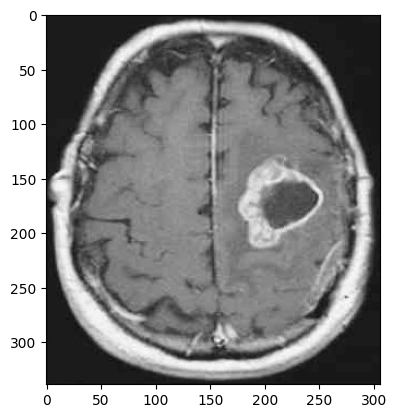

In [ ]:
image = Image.open('/content/drive/MyDrive/IT1244/images/malignant/10.jpg')
# image = Image.open('/content/drive/MyDrive/NUS/2023 2024 Sem 1/IT1244/images/malignant/10.jpg') # swap to this when ur running
plt.imshow(image)

image = transform(image)
print(f"Image shape before: {image.shape}")
image = image.unsqueeze(0)
print(f"Image shape after: {image.shape}")

In [ ]:
outputs = []
names = []
for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
print(len(outputs))
#print first 10 feature_maps
for feature_map in outputs[:10]:
    print(feature_map.shape)

16
torch.Size([1, 64, 224, 224])
torch.Size([1, 64, 224, 224])
torch.Size([1, 128, 224, 224])
torch.Size([1, 128, 224, 224])
torch.Size([1, 256, 224, 224])
torch.Size([1, 256, 224, 224])
torch.Size([1, 256, 224, 224])
torch.Size([1, 256, 224, 224])
torch.Size([1, 512, 224, 224])
torch.Size([1, 512, 224, 224])


In [ ]:
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())

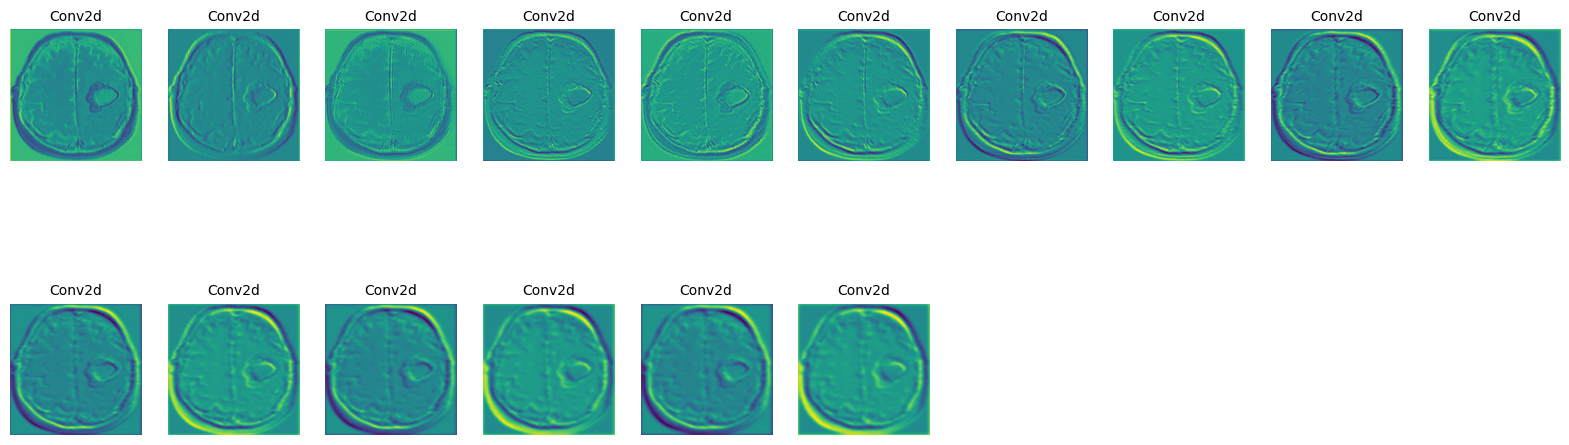

In [ ]:
fig = plt.figure(figsize=(20, 60))
for i in range(len(processed)):
    a = fig.add_subplot(17, 10, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=10)

# Hyperparameter tuning

## Manual Looping

In [13]:
def update_best_params(metric, best_params, score, epochs, batch_size, lr):
  """
  Update the best hyperparameters for a given metric.

  Parameters:
  - metric (str): The metric for which to update the best hyperparameters.
  - best_params (dict): A dictionary containing the best hyperparameters for different metrics.
  - score (float): The performance score associated with the hyperparameters.
  - epochs (int): The number of training epochs.
  - batch_size (int): The batch size used during training.
  - lr (float): The learning rate used during training.

  Returns:
  - best_params (dict): The updated dictionary of best hyperparameters.

  Example:
  best_params = {
      'precision': {'score': 0.95, 'num_epochs': 10, 'batch_size': 32, 'learning_rate': 0.001},
      'recall': {'score': 0.90, 'num_epochs': 15, 'batch_size': 64, 'learning_rate': 0.005}
  }
  updated_best_params = update_best_params('precision', best_params, 0.97, 12, 32, 0.002)
  """
  best_params[metric]['score'] = score
  best_params[metric]['num_epochs'] = epochs
  best_params[metric]['batch_size'] = batch_size
  best_params[metric]['learning_rate'] = lr
  return best_params

In [15]:
# Define hyperparameters to tune
num_epochs_list = [10, 20]
batch_size_list = [16, 32]
learning_rate_list = [0.0001, 0.001, 0.01]

# Initialize a dictionary to store the best hyperparameters for different metrics
best_params = {'accuracy': {'score': float('-inf')},
               'precision': {'score': float('-inf')},
               'recall': {'score': float('-inf')},
               'specificity': {'score': float('-inf')},
               'f1': {'score': float('-inf')},
               'roc_auc': {'score': float('-inf')},
               'pr_auc': {'score': float('-inf')}}

# Check if CUDA is available and set the device accordingly
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using: {device}")

# Cross-validation settings
n_splits = 5  # Number of splits for cross-validation
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize the augmentation class
augmentation = Augmentation()

# Initialize lists to store metrics for each hyperparameter combination
hyperparam_accuracies = []
hyperparam_precisions = []
hyperparam_recalls = []
hyperparam_specificities = []
hyperparam_f1_scores = []
hyperparam_roc_aucs = []
hyperparam_pr_aucs = []

# Loop through different hyperparameter combinations
for num_epochs in num_epochs_list:
    for batch_size in batch_size_list:
        for learning_rate in learning_rate_list:
            print(f"Hyperparameters: num_epochs={num_epochs}, batch_size={batch_size}, learning_rate={learning_rate}")

            # Initialize lists to store metrics for each fold
            fold_accuracies = []
            fold_precisions = []
            fold_recalls = []
            fold_specificities = []
            fold_f1_scores = []
            fold_confusion_matrices = []
            fold_roc_aucs = []
            fold_pr_aucs = []

            # Loop through the folds of cross-validation
            for fold, (train_index, val_index) in enumerate(skf.split(standard_dataset.imgs, [y for x, y in standard_dataset.samples])):
                print(f"Training Fold {fold + 1}/{n_splits}")

                # Split the dataset into training and validation sets for this fold
                train_dataset = torch.utils.data.Subset(standard_dataset, train_index)
                val_dataset = torch.utils.data.Subset(standard_dataset, val_index)

                # Apply data augmentation to the training dataset
                augmented_images = []
                for img_label in train_dataset:
                  augmented_images.extend(augmentation(img_label))

                # Transform the validation dataset
                transformed_val_dataset = []
                for img_label in val_dataset:
                    img, label = img_label
                    transformed_img = validation_transform(img)
                    transformed_val_dataset.append((transformed_img, label))

                # Create data loaders for training and validation
                train_loader = DataLoader(augmented_images, batch_size=32, shuffle=True, num_workers=2)
                val_loader = DataLoader(transformed_val_dataset, batch_size=batch_size, num_workers=2)
                print(f"initial training dataset size: {len(train_dataset)}, post-transformation training dataset size: {len(augmented_images)}, validation dataset size: {len(transformed_val_dataset)}")

                # Initialize the model
                model = VGG19()
                model.to(device)

                # Define loss function and optimizer
                criterion = nn.BCELoss()
                optimizer = optim.Adam(model.parameters(), lr=learning_rate)

                # Training loop
                for epoch in range(num_epochs):
                    avg_loss = train(model, train_loader, criterion, optimizer, device)
                    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}")

                # Validation
                true_labels, predicted_labels, predicted_probas = validate(model, val_loader, criterion, optimizer, device)

                roc_auc = roc_auc_score(true_labels, predicted_probas)
                precision, recall, _ = precision_recall_curve(true_labels, predicted_probas)
                pr_auc = auc(recall, precision)
                precision = precision_score(true_labels, predicted_labels)
                recall = recall_score(true_labels, predicted_labels)
                f1 = f1_score(true_labels, predicted_labels)
                tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels).ravel()
                accuracy = (tp + tn) / (tn + fp + fn + tp)
                specificity = tn / (tn + fp)

                # Store fold metrics
                fold_accuracies.append(accuracy)
                fold_precisions.append(precision)
                fold_recalls.append(recall)
                fold_specificities.append(specificity)
                fold_f1_scores.append(f1)
                fold_confusion_matrices.append((tn, fp, fn, tp))
                fold_roc_aucs.append(roc_auc)
                fold_pr_aucs.append(pr_auc)

                # Print fold metrics
                print(f"Validation Accuracy (Fold {fold + 1}/{n_splits}): {accuracy:.2f}")
                print(f"Precision (Fold {fold + 1}/{n_splits}): {precision:.2f}")
                print(f"Recall (Fold {fold + 1}/{n_splits}): {recall:.2f}")
                print(f"Specificity (Fold {fold + 1}/{n_splits}): {specificity:.2f}")
                print(f"F1 Score (Fold {fold + 1}/{n_splits}): {f1:.2f}")
                print(f"Confusion Matrix (Fold {fold + 1}/{n_splits}): TN={tn}, FP={fp}, FN={fn}, TP={tp}")
                print(f"ROC-AUC (Fold {fold + 1}/{n_splits}): {roc_auc:.2f}")
                print(f"PR-AUC (Fold {fold + 1}/{n_splits}): {pr_auc:.2f}")

            # Calculate and store the mean metrics for this hyperparameter combination
            mean_accuracy = np.mean(fold_accuracies)
            hyperparam_accuracies.append(mean_accuracy)

            mean_recall = np.mean(fold_recalls)
            hyperparam_recalls.append(mean_recall)

            mean_precision = np.mean(fold_precisions)
            hyperparam_precisions.append(mean_precision)

            mean_specificity = np.mean(fold_specificities)
            hyperparam_specificities.append(mean_specificity)

            mean_f1_score = np.mean(fold_f1_scores)
            hyperparam_f1_scores.append(mean_f1_score)

            mean_roc_auc = np.mean(fold_roc_aucs)
            hyperparam_roc_aucs.append(mean_roc_auc)

            mean_pr_auc = np.mean(fold_pr_aucs)
            hyperparam_pr_aucs.append(mean_pr_auc)

            # Update best hyperparameters for each metric
            if mean_accuracy > best_params['accuracy']['score']:
              best_params = update_best_params('accuracy', best_params, mean_accuracy, num_epochs, batch_size, learning_rate)
            if mean_precision > best_params['precision']['score']:
              best_params = update_best_params('precision', best_params, mean_precision, num_epochs, batch_size, learning_rate)
            if mean_recall > best_params['recall']['score']:
              best_params = update_best_params('recall', best_params, mean_recall, num_epochs, batch_size, learning_rate)
            if mean_specificity > best_params['specificity']['score']:
              best_params = update_best_params('specificity', best_params, mean_specificity, num_epochs, batch_size, learning_rate)
            if mean_f1_score > best_params['f1']['score']:
              best_params = update_best_params('f1', best_params, mean_f1_score, num_epochs, batch_size, learning_rate)
            if mean_roc_auc > best_params['roc_auc']['score']:
              best_params = update_best_params('roc_auc', best_params, mean_roc_auc, num_epochs, batch_size, learning_rate)
            if mean_pr_auc > best_params['pr_auc']['score']:
              best_params = update_best_params('pr_auc', best_params, mean_pr_auc, num_epochs, batch_size, learning_rate)

print(f"Best hyperparameters: {best_params}")

Using: cuda:0
Hyperparameters: num_epochs=10, batch_size=16, learning_rate=0.0001
Training Fold 1/5
initial training dataset size: 184, post-transformation training dataset size: 1840, validation dataset size: 46
Epoch [1/10] - Loss: 0.3751
Epoch [2/10] - Loss: 0.0860
Epoch [3/10] - Loss: 0.0276
Epoch [4/10] - Loss: 0.0153
Epoch [5/10] - Loss: 0.0108
Epoch [6/10] - Loss: 0.0029
Epoch [7/10] - Loss: 0.0067
Epoch [8/10] - Loss: 0.0094
Epoch [9/10] - Loss: 0.0225
Epoch [10/10] - Loss: 0.0170
Validation Accuracy (Fold 1/5): 0.87%
Precision (Fold 1/5): 0.90
Recall (Fold 1/5): 0.90
Specificity (Fold 1/5): 0.81
F1 Score (Fold 1/5): 0.90
Confusion Matrix (Fold 1/5): TN=13, FP=3, FN=3, TP=27
ROC-AUC (Fold 1/5): 0.94
PR-AUC (Fold 1/5): 0.97
Training Fold 2/5
initial training dataset size: 184, post-transformation training dataset size: 1840, validation dataset size: 46
Epoch [1/10] - Loss: 0.3488
Epoch [2/10] - Loss: 0.0773
Epoch [3/10] - Loss: 0.0156
Epoch [4/10] - Loss: 0.0105
Epoch [5/10] - L

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy (Fold 3/5): 0.33%
Precision (Fold 3/5): 0.00
Recall (Fold 3/5): 0.00
Specificity (Fold 3/5): 1.00
F1 Score (Fold 3/5): 0.00
Confusion Matrix (Fold 3/5): TN=15, FP=0, FN=31, TP=0
ROC-AUC (Fold 3/5): 0.50
PR-AUC (Fold 3/5): 0.84
Training Fold 4/5
initial training dataset size: 184, post-transformation training dataset size: 1840, validation dataset size: 46
Epoch [1/20] - Loss: 33.3635
Epoch [2/20] - Loss: 33.6746
Epoch [3/20] - Loss: 33.5668
Epoch [4/20] - Loss: 33.7284
Epoch [5/20] - Loss: 33.7284
Epoch [6/20] - Loss: 33.7823
Epoch [7/20] - Loss: 33.8362
Epoch [8/20] - Loss: 33.6746
Epoch [9/20] - Loss: 33.5129
Epoch [10/20] - Loss: 33.5668
Epoch [11/20] - Loss: 33.6207
Epoch [12/20] - Loss: 33.6746
Epoch [13/20] - Loss: 33.8362
Epoch [14/20] - Loss: 33.6207
Epoch [15/20] - Loss: 33.6746
Epoch [16/20] - Loss: 33.7284
Epoch [17/20] - Loss: 33.8362
Epoch [18/20] - Loss: 33.6746
Epoch [19/20] - Loss: 33.7284
Epoch [20/20] - Loss: 33.5668
Validation Accuracy (Fold 4/5):

Best hyperparameters: {'accuracy': {'score': 0.8565217391304347, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 0.0001}, 'precision': {'score': 0.9216856118791602, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 0.0001}, 'recall': {'score': 1.0, 'num_epochs': 10, 'batch_size': 16, 'learning_rate': 0.01}, 'specificity': {'score': 0.8574999999999999, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 0.0001}, 'f1': {'score': 0.8940993471650147, 'num_epochs': 10, 'batch_size': 32, 'learning_rate': 0.0001}, 'roc_auc': {'score': 0.9230107526881721, 'num_epochs': 10, 'batch_size': 32, 'learning_rate': 0.0001}, 'pr_auc': {'score': 0.9591453774477872, 'num_epochs': 10, 'batch_size': 32, 'learning_rate': 0.0001}}

# Training with tuned hyperparameters

In [22]:
train_dataset, val_dataset = torch.utils.data.random_split(standard_dataset, [int(0.8 * len(standard_dataset)), int(0.2 * len(standard_dataset))])

In [23]:
# Define hyperparameters
num_epochs = 10  # Number of training epochs
batch_size = 32
learning_rate = 0.0001
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using: {device}")

augmentation = Augmentation()

augmented_images = []
for img_label in train_dataset:
    augmented_images.extend(augmentation(img_label))

transformed_val_dataset = []
for img_label in val_dataset:
    img, label = img_label
    transformed_img = validation_transform(img)
    transformed_val_dataset.append((transformed_img, label))

train_loader = DataLoader(augmented_images, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(transformed_val_dataset, batch_size=batch_size, num_workers=2)
print(f"initial training dataset size: {len(train_dataset)}, post-transformation training dataset size: {len(augmented_images)}, validation dataset size: {len(transformed_val_dataset)}")

model = VGG19()
model.to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    avg_loss = train(model, train_loader, criterion, optimizer, device)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}")

# Validation
true_labels, predicted_labels, predicted_probas = validate(model, val_loader, criterion, optimizer, device)

roc_auc = roc_auc_score(true_labels, predicted_probas)
precision, recall, _ = precision_recall_curve(true_labels, predicted_probas)
pr_auc = auc(recall, precision)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels).ravel()
accuracy = (tp + tn) / (tn + fp + fn + tp)
specificity = tn / (tn + fp)
print(f"Validation Accuracy: {accuracy:.2f}")
print(f"Validation Precision: {precision:.2f}")
print(f"Validation Recall: {recall:.2f}")
print(f"Validation Specificity: {specificity:.2f}")
print(f"Validation F1 Score: {f1:.2f}")
print(f"Validation Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}")
print(f"Validation ROC-AUC: {roc_auc:.2f}")
print(f"Validation PR-AUC: {pr_auc:.2f}")

Using: cuda:0
initial training dataset size: 184, post-transformation training dataset size: 1840, validation dataset size: 46
Epoch [1/10] - Loss: 0.3945
Epoch [2/10] - Loss: 0.0894
Epoch [3/10] - Loss: 0.0381
Epoch [4/10] - Loss: 0.0201
Epoch [5/10] - Loss: 0.0090
Epoch [6/10] - Loss: 0.0076
Epoch [7/10] - Loss: 0.0083
Epoch [8/10] - Loss: 0.0050
Epoch [9/10] - Loss: 0.0230
Epoch [10/10] - Loss: 0.0248
Validation Accuracy: 0.85
Validation Precision: 0.93
Validation Recall: 0.85
Validation Specificity: 0.85
Validation F1 Score: 0.89
Validation Confusion Matrix: TN=11, FP=2, FN=5, TP=28
Validation ROC-AUC: 0.95
Validation PR-AUC: 0.98
